# Final Project



## Group Contribution Statement.


All three of us wrote the data acquisition and preparation. Zechen Liu works on the data import and cleaning, the support vector model, Graph 1, and automated feature selection. Dylan Kawashiri wrote the Neural Network Model, Tables 1 and 2, and Graph 4. Jingxi Lin did the bar graphs (Graphs 2 and 3), .feature scores to select the best feature (for the random forest model), and the random forest model.


In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, preprocessing
import urllib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

In [2]:
#data import
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)

In [3]:
#shorten the name of species
penguins["Species"] = penguins["Species"].str.split().str.get(0)
#drop the comments column
penguins = penguins.drop(['Comments'], axis = 1)
#remove the particular row of sex that is not properly recorded
penguins = penguins[penguins["Sex"] != "."]
penguins = penguins.dropna()
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
1,PAL0708,2,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454
2,PAL0708,3,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302
4,PAL0708,5,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426
5,PAL0708,6,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,11/16/07,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805
6,PAL0708,7,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N4A1,No,11/15/07,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799


In [4]:
penguins.shape

(324, 16)

The columns we will be using in our machine learning models are:


*   **Species**: penguin species (Adelie, Chinstrap, Gentoo)
*   **Island**: penguin island
*   **Sex**: penguin sex
*   **Culmen Length (mm)**: penguin beak length
*   **Culmen Depth (mm)**: penguin beak depth
*   **Body Mass (g)**: penguin body mass
*   **Flipper Length (mm)**: penguin flipper length
*   **Delta 15 N (o/oo)**: nitrogen isotope in penguin bloodstream
*   **Delta 13 C (o/oo)**: carbon isotope in penguin bloodstream

In [5]:
#Split data into train set and test set
np.random.seed(3354354524)
train, test = train_test_split(penguins, test_size = 0.2)

In [6]:
def prep_penguin_data(data_df):
    '''
    Obtain slices X and y (predictor variables and target variable) from the penguins dataframe,
    and encode the sex (inside X) and the species (y) of the penguins as integers
    '''
  # drop columns we don't need
    df = data_df.copy()
    df = df[["Species", "Island", "Sex", "Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)", "Flipper Length (mm)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]]
  
    le = preprocessing.LabelEncoder()
  # convert female/male to 0/1
    df['Sex'] = le.fit_transform(df['Sex'])
  # convert Biscoe/Dream/Torgersen island to 0/1/2
    df['Island'] = le.fit_transform(df['Island'])
  # convert Adelie/Chinstrap/Gentoo to 0/1/2
    df['Species'] = le.fit_transform(df['Species'])
  
  # split into X (predictor variables) and y (target variable)
    X = df.drop(['Species'], axis = 1)
    y = df['Species']
    return(X, y)

In [7]:
#Perform cleaning process on both train and test set
X_train, y_train = prep_penguin_data(train)
X_test,  y_test  = prep_penguin_data(test)

## Exploratory Analysis

In [8]:
penguins = penguins.drop(['studyName'], axis = 1)
penguins = penguins.drop(['Sample Number'], axis = 1)
penguins = penguins.drop(['Stage'], axis = 1)
penguins = penguins.drop(['Individual ID'], axis = 1)
penguins = penguins.drop(['Clutch Completion'], axis = 1)
penguins = penguins.drop(['Date Egg'], axis = 1)
penguins = penguins.drop(["Region"], axis = 1)

penguins.head()

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,FEMALE,9.18718,-25.21799


Table 1

In [9]:
#statistical data for penguins, categorized by species, island, and sex. basic overview. 
penguins_describe = penguins.groupby(["Species","Island", "Sex"]).describe().T
penguins_describe

Species                         Adelie                                         \
Island                          Biscoe                     Dream                
Sex                             FEMALE         MALE       FEMALE         MALE   
Culmen Length (mm)  count    22.000000    22.000000    27.000000    25.000000   
                    mean     37.359091    40.590909    36.911111    40.012000   
                    std       1.762212     2.006634     2.089043     1.834466   
                    min      34.500000    37.600000    32.100000    36.300000   
                    25%      35.750000    39.025000    36.000000    39.000000   
                    50%      37.750000    40.800000    36.800000    40.200000   
                    75%      38.475000    41.550000    37.850000    41.100000   
                    max      40.500000    45.600000    42.200000    44.100000   
Culmen Depth (mm)   count    22.000000    22.000000    27.000000    25.000000   
                    mean     17.704545    19.036364    17.618519    18.840000   
                    std       1.091298     0.879689     0.897448     1.090489   
                    min      16.000000    17.200000    15.500000    17.000000   
                    25%      17.000000    18.600000    17.050000    18.100000   
                    50%      17.700000    18.900000    17.800000    18.600000   
                    75%      18.250000    19.500000    18.450000    19.500000   
                    max      20.700000    21.100000    19.300000    21.200000   
Flipper Length (mm) count    22.000000    22.000000    27.000000    25.000000   
                    mean    187.181818   190.409091   187.851852   192.520000   
                    std       6.744567     6.463517     5.510156     6.677824   
                    min     172.000000   180.000000   178.000000   178.000000   
                    25%     184.250000   185.750000   185.000000   190.000000   
                    50%     187.000000   191.000000   188.000000   191.000000   
                    75%     191.750000   194.750000   191.000000   196.000000   
                    max     199.000000   203.000000   202.000000   208.000000   
Body Mass (g)       count    22.000000    22.000000    27.000000    25.000000   
                    mean   3369.318182  4050.000000  3344.444444  4052.000000   
                    std     343.470715   355.567956   212.056475   301.205910   
                    min    2850.000000  3550.000000  2900.000000  3475.000000   
                    25%    3150.000000  3800.000000  3212.500000  3900.000000   
                    50%    3375.000000  4000.000000  3400.000000  4000.000000   
                    75%    3693.750000  4268.750000  3487.500000  4300.000000   
                    max    3900.000000  4775.000000  3700.000000  4600.000000   
Delta 15 N (o/oo)   count    22.000000    22.000000    27.000000    25.000000   
                    mean      8.774242     8.872945     8.914803     8.984427   
                    std       0.398858     0.367889     0.503147     0.321221   
                    min       8.081380     8.353960     8.014850     8.394590   
                    25%       8.490100     8.630645     8.603990     8.796650   
                    50%       8.755420     8.828740     8.934650     8.975330   
                    75%       9.026533     8.993085     9.326010     9.189850   
                    max       9.795320     9.639540     9.697560     9.727640   
Delta 13 C (o/oo)   count    22.000000    22.000000    27.000000    25.000000   
                    mean    -25.920176   -25.917227   -25.736636   -25.759120   
                    std       0.604133     0.496058     0.579383     0.628180   
                    min     -26.789580   -26.600230   -26.695430   -26.579410   
                    25%     -26.266738   -26.365840   -26.096820   -26.096350   
                    50%     -26.094190   -25.942600   -25.830600   -26.015490   
                    75%     -25

Table 2

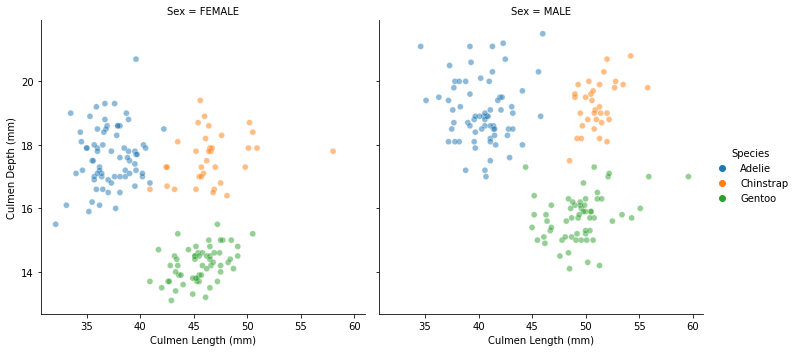

In [10]:
#Scatter plot for the penguins graphing culmen length by culmen depth. Separated by Sex and Species. 
sns.relplot(x = "Culmen Length (mm)", 
            y = "Culmen Depth (mm)",
            hue = "Species", 
            data = penguins,
            col = "Sex",
            height = 5,
            aspect = 1,
            alpha = 0.5
            )

Graph 1

The scatter plot plots the relationship between the Culmen length and Culmen depth of penguins. It is obvious that the different speicies of penguins has distinct Culmen length and depth. For example, Chinstrap has the largest Culmen length and depth on average, and male penguins have larger Culmen length and depth on average. The graph provides good features, which are Culmen length and depth, for modeling.

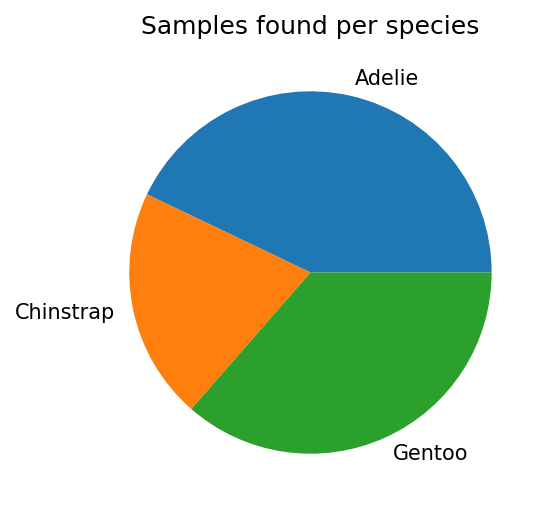

In [11]:
#Histogram for the number of penguins in each species. 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
df_group_species = penguins.groupby(['Species']).size().plot(kind='pie')
plt.ylabel("")
plt.title("Samples found per species")
plt.show()

Graph 2

For this graph, we saw that the Adelie penguins are the largest group. As a result, it is expected that these penguins are the best predicted as there is a larger sample size.

C:\Users\ZECHEN~1\AppData\Local\Temp/ipykernel_5220/2398253964.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group_02 = penguins.groupby(['Species'])['Culmen Length (mm)','Culmen Depth (mm)','Flipper Length (mm)','Body Mass (kg)'].mean().plot(kind='bar',figsize=(20,6))


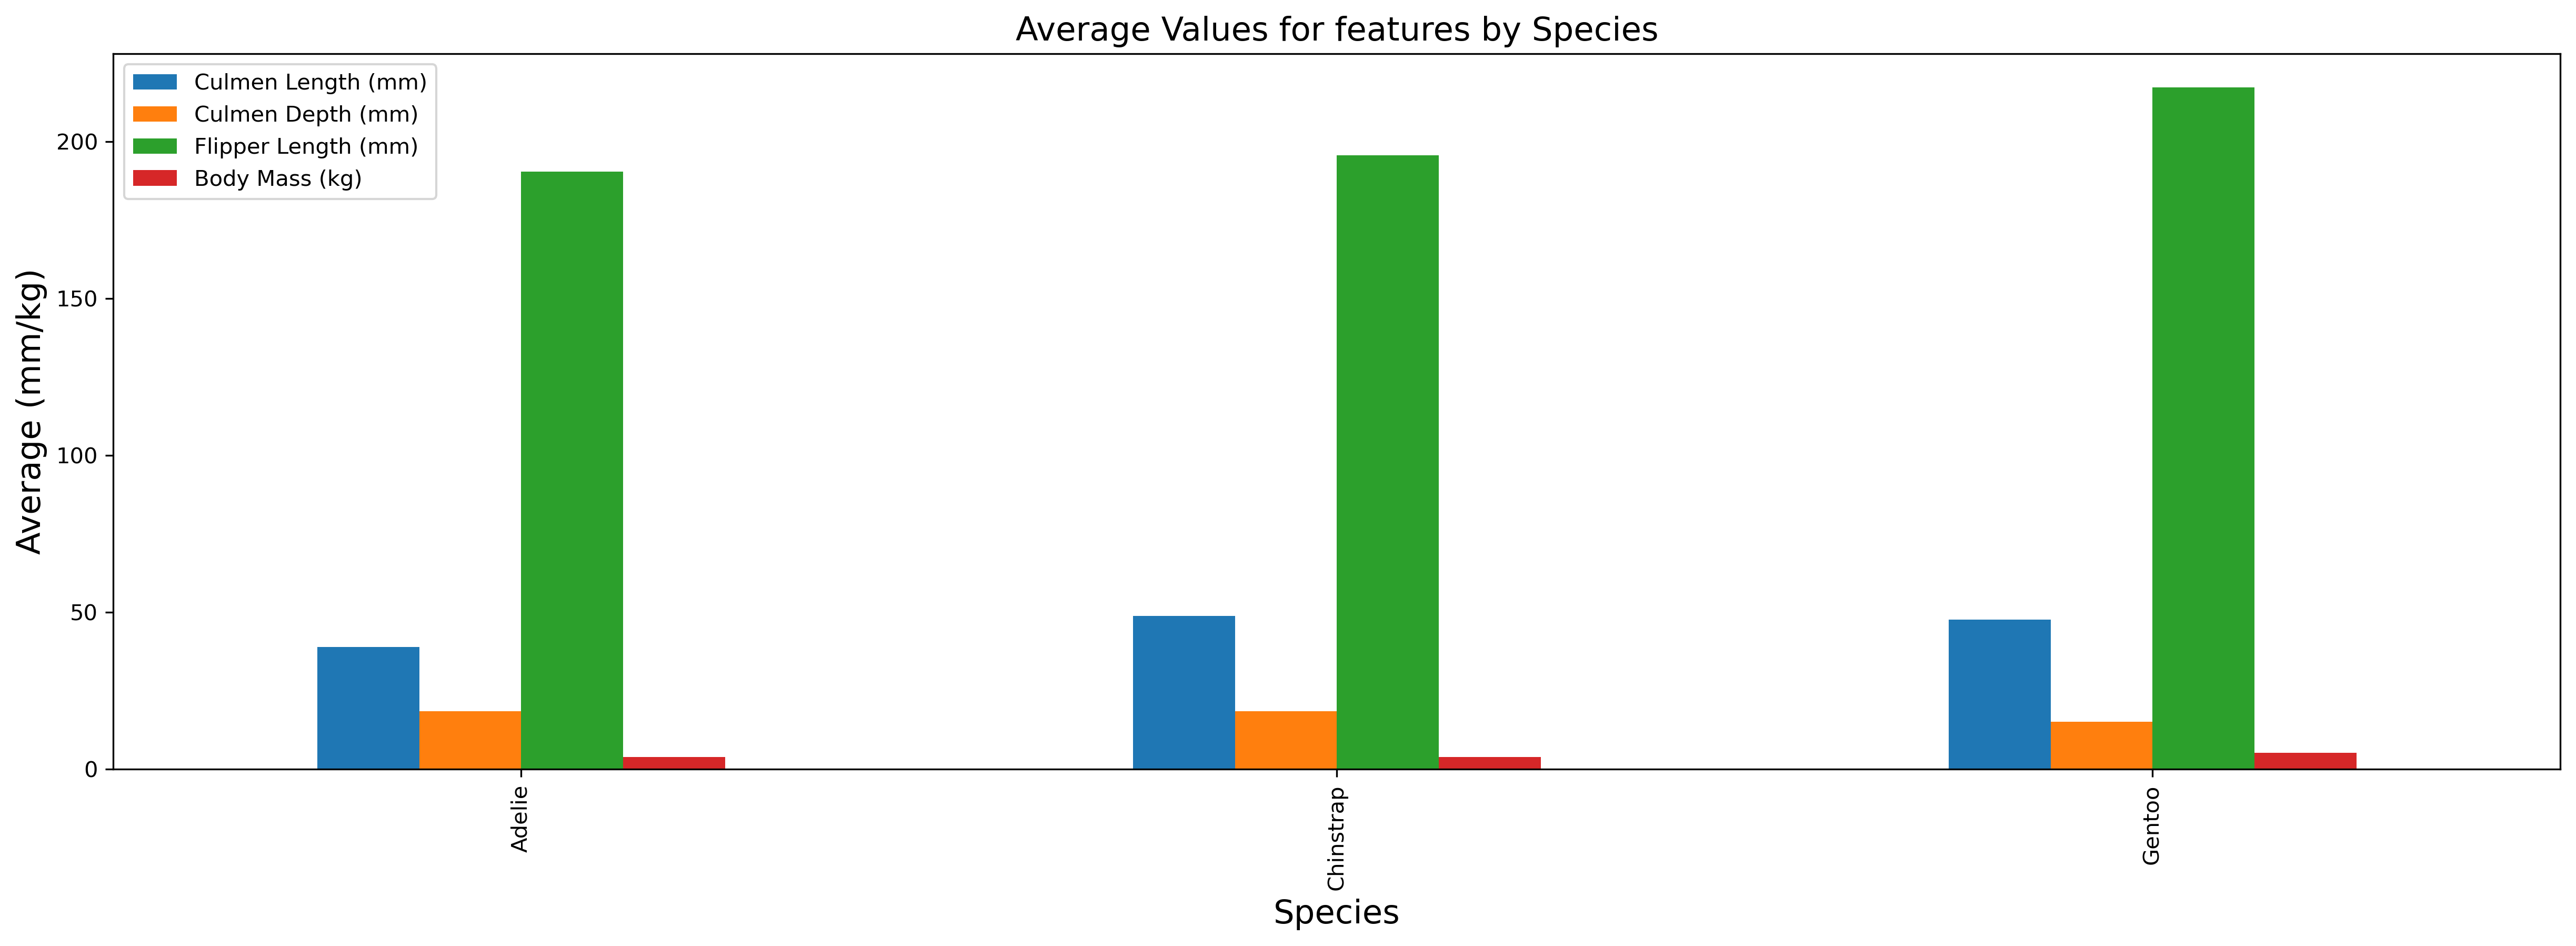

In [12]:
#Average culmen leng, culmen depth, flipper length, and body mass (in kg) for each species of penguins. 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
#average comparison by graph
penguins["Body Mass (kg)"] = penguins["Body Mass (g)"]/1000
df_group_02 = penguins.groupby(['Species'])['Culmen Length (mm)','Culmen Depth (mm)','Flipper Length (mm)','Body Mass (kg)'].mean().plot(kind='bar',figsize=(20,6))
plt.xlabel("Species",fontsize=15)
plt.ylabel("Average (mm/kg)",fontsize=15)
plt.title("Average Values for features by Species",fontsize=15)
plt.show()

Graph 3

The larger variations in flipper length and culmen length show that these features are good for usage in the random forest model, as shown below. This information was further confirmed in the feature selection process. 

Graph 4 in the Feature Selection section is also a graph we used for explatory analysis. From the graph we were able to see how the different measurements varied between the different species, on each island. This allowed us to make better decisions for our models.

## Feature Selection

In [13]:
def exhaustive_search(model, X, y):
    """
    The exhaustive search function takes one of the models and the predicting and target value as inputs. It then finds the best combination of one qualitative
    and two quantitative columns based on the score from the models. It then outputs these columns and the corresponding score for use later on. 
    """
    best_cv = 0
    best_cols = []
    
    # Search for all combinations of column subsets with length of r=3
    cols = list(combinations(X.columns,3))

    for features in cols:
        features = list(features)
        #Find subsets with one qualitative variable and two quantitative variables
        if ("Island" in features and "Sex" not in features) or ("Sex" in features and "Island" not in features):
            cv_score = cross_val_score(model, X[features], y, cv=5).mean()
            # Find best CV score and best subsets for model
            if cv_score > best_cv:
                best_cv = cv_score
                best_cols = list(features)
                
    return best_cv, best_cols


From this function, it was shown that for the Support Vector model and Neural Network model that the Island, Culmen Length, and Culmen Depth columns provided the best score. 

Below is the feature selection prcoess for the Random Forest Model. The results from this vary from the one shown previously. 


In [14]:
mpl.rcParams['figure.dpi'] = 150
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
df = penguins
df = df[["Species", "Island", "Sex", "Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)", "Flipper Length (mm)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]]
  
le = preprocessing.LabelEncoder()
# convert male/female to 1/0
df['Sex'] = le.fit_transform(df['Sex'])
# convert Biscoe/Dream/Torgersen island to 0/1/2
df['Island'] = le.fit_transform(df['Island'])
# convert Adelie/Chinstrap/Gentoo to 0/1/2
df['Species'] = le.fit_transform(df['Species'])
# split into X (predictor variables) and y (target variable)
X = df.drop(['Species'], axis = 1)
y = df['Species']


bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,y)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)

ScoresFeatures = pd.concat([columns,scores],axis=1)
ScoresFeatures.columns = ['Feature','Score']  #naming the dataframe columns
print(ScoresFeatures.nlargest(12,'Score'))

               Feature       Score
5  Flipper Length (mm)  548.060798
2   Culmen Length (mm)  379.549037
3    Culmen Depth (mm)  334.706252
4        Body Mass (g)  333.566922
7    Delta 13 C (o/oo)  219.796612
6    Delta 15 N (o/oo)  210.225864
0               Island  137.082771
1                  Sex    0.050162


C:\Users\ZECHEN~1\AppData\Local\Temp/ipykernel_5220/1679679136.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = le.fit_transform(df['Sex'])
C:\Users\ZECHEN~1\AppData\Local\Temp/ipykernel_5220/1679679136.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Island'] = le.fit_transform(df['Island'])
C:\Users\ZECHEN~1\AppData\Local\Temp/ipykernel_5220/1679679136.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

From this, it can be seen that the two quantitative columns of Flipper Length (mm) and Culmen Length (mm) gave the highest scores. As a result, these columns were used for the Random Forest model along with Island, which had the highest score of the qualitative columns. 

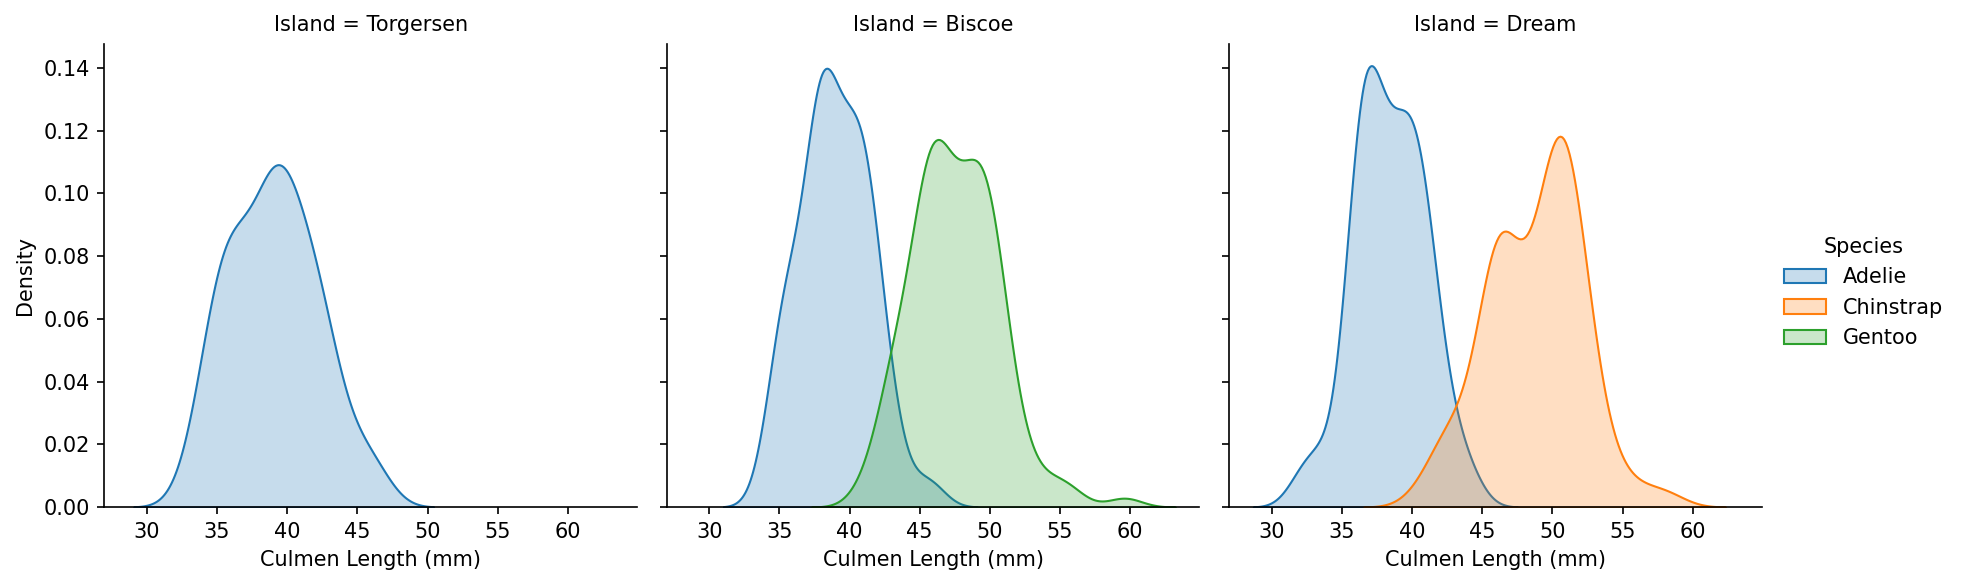

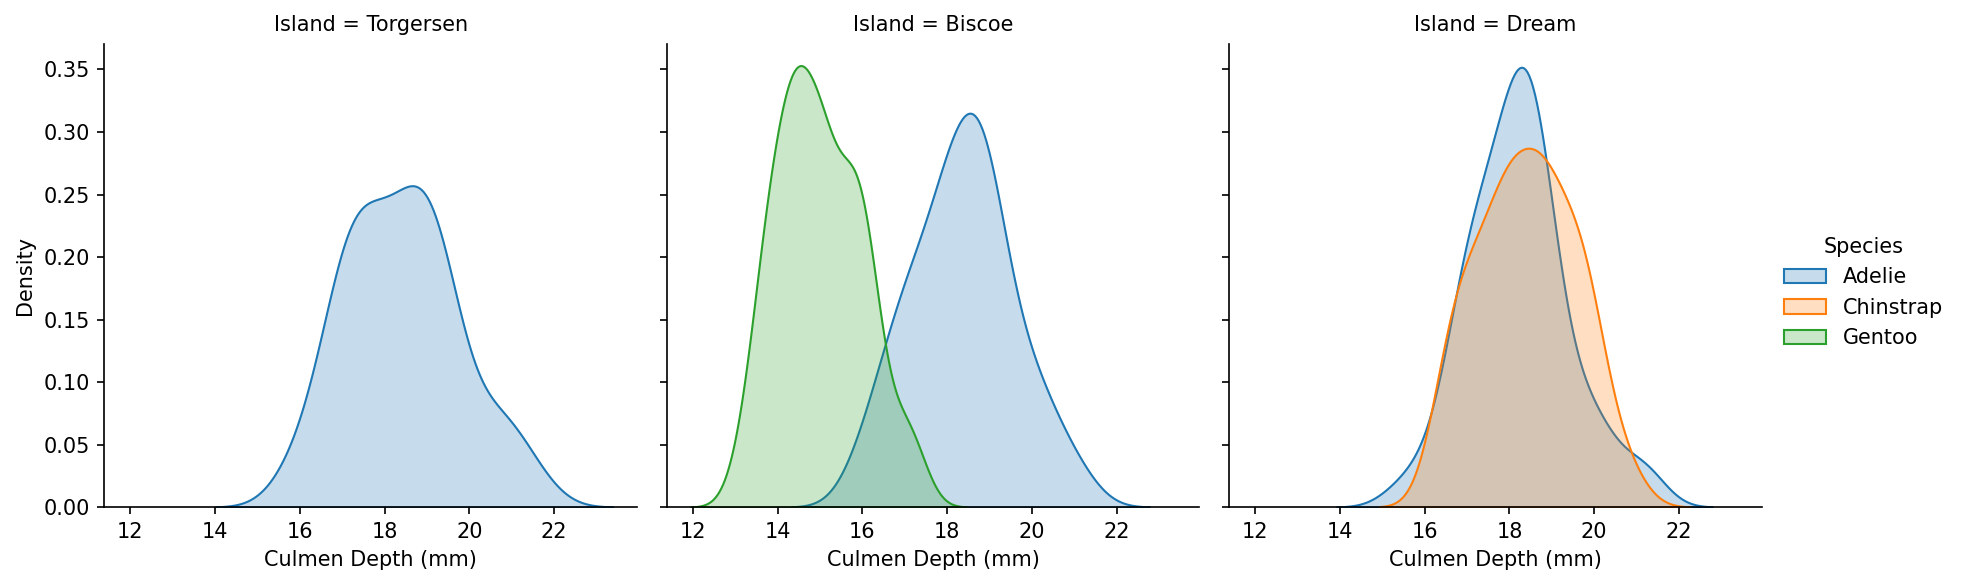

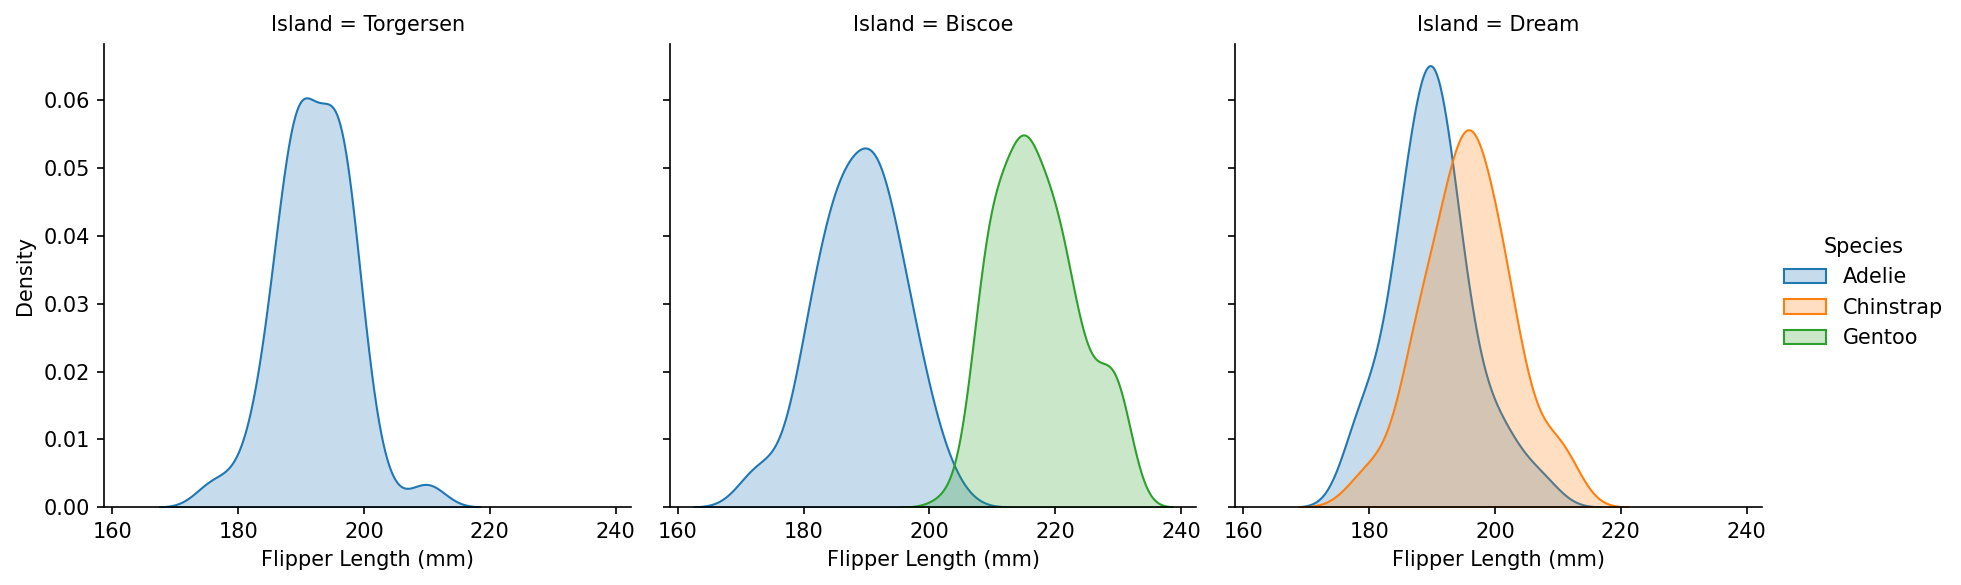

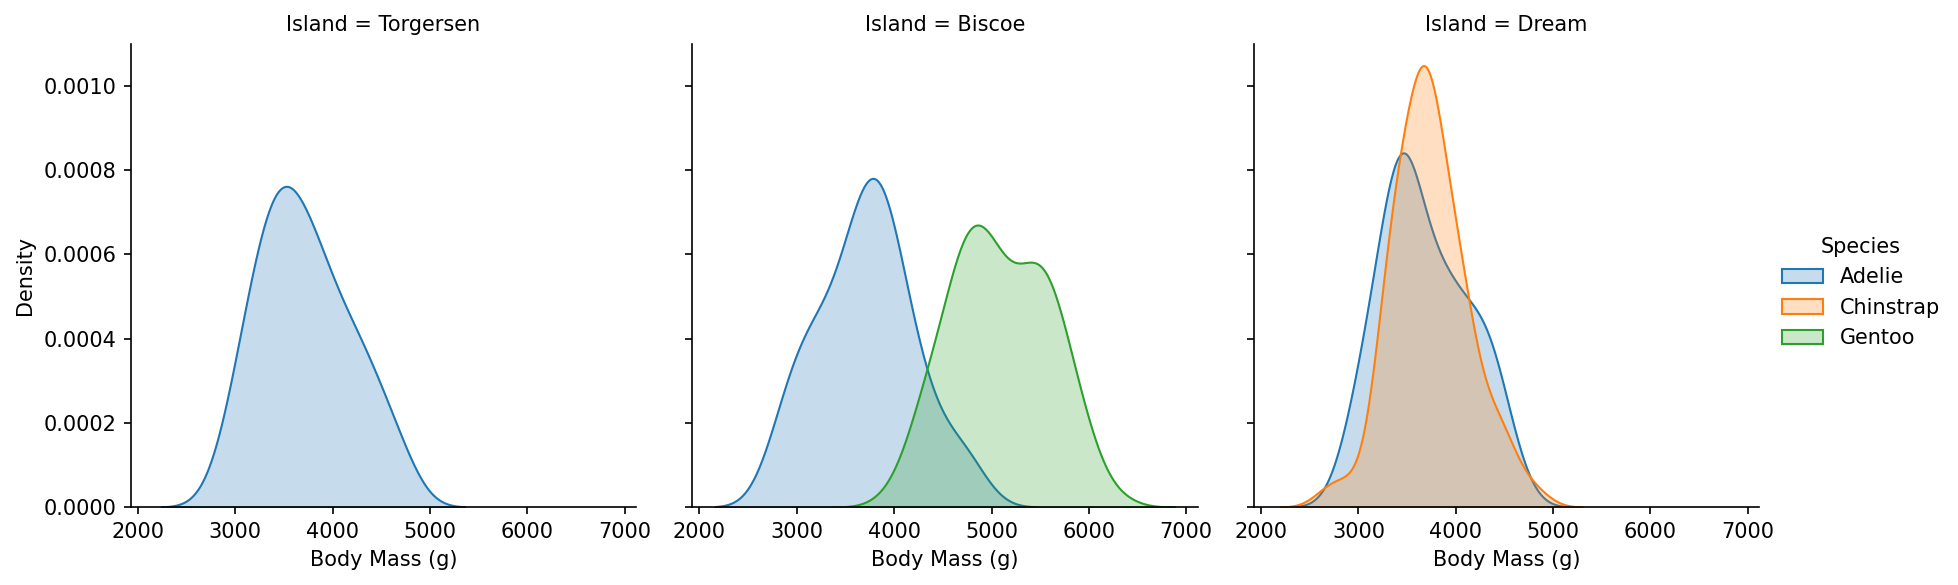

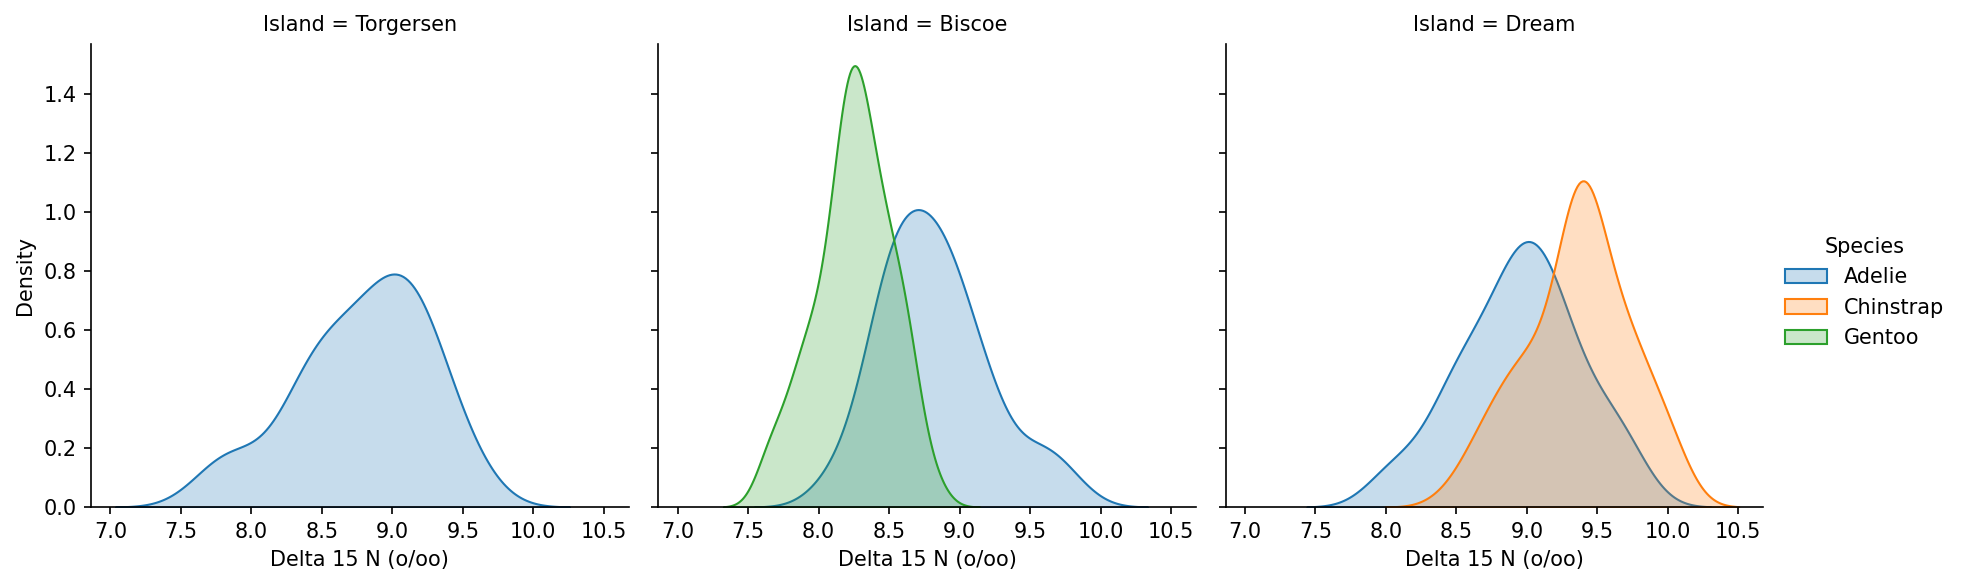

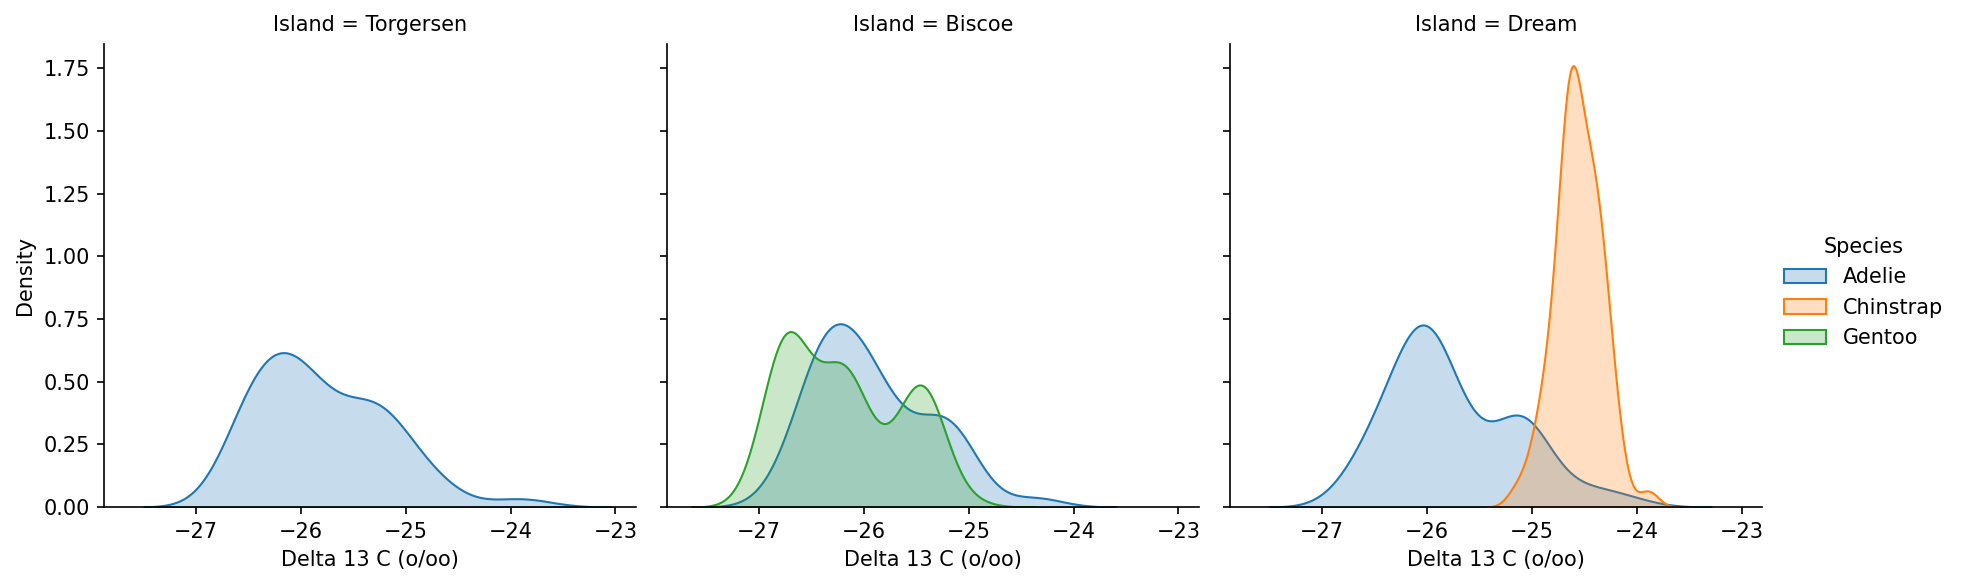

In [15]:
#Creates density graphs for every quantitative value, separated by Island and Species.
penguins.dropna()
cols = ["Culmen Length (mm)", "Culmen Depth (mm)","Flipper Length (mm)", "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]

for i in range(len(cols)):
    g = sns.FacetGrid(penguins, hue = "Species", col = "Island", height = 4) 
    g.map(sns.kdeplot, cols[i], shade = True)
    g.add_legend()

Graph 4

These graphs above also show how the given qualitative and quantitative columns from the exhaustive search function are accurate. As seen in the graphs,
the culmen length, culmen depth, and flipper length variables have the most variation. Additionally, the Island column (for qualitative) is the best as certain islands
only have one species of penguins on it. This is also confirmed in Table 2, where the averages and standard deviations match up with this information.

## Support Vector Machine

In [16]:
def best_C(X, y):
    """
    Inputs target and predictor variables. Finds and returns the best value for the compexity parameter based on the score from the SV model. 
    """
    fig, ax = plt.subplots()
    best_score = 0
    
    for i in range(1, 15):
        model = SVC(kernel='poly', C=i)
        cv_score = cross_val_score(model, X, y, cv=5).mean()
        ax.scatter(i, cv_score, color='blue')
        
        if cv_score > best_score:
            best_C = i
            best_score = cv_score
            
    ax.set(xlabel="C_value", ylabel="score")
    return best_C, best_score

In [17]:
cols = ["Island", "Sex", "Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)", "Flipper Length (mm)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
svm = SVC(kernel='poly')
best_svm_cv, best_svm_cols = exhaustive_search(svm, X_train[cols], y_train)
best_svm_cv, best_svm_cols

(0.96131221719457, ['Island', 'Culmen Length (mm)', 'Culmen Depth (mm)'])

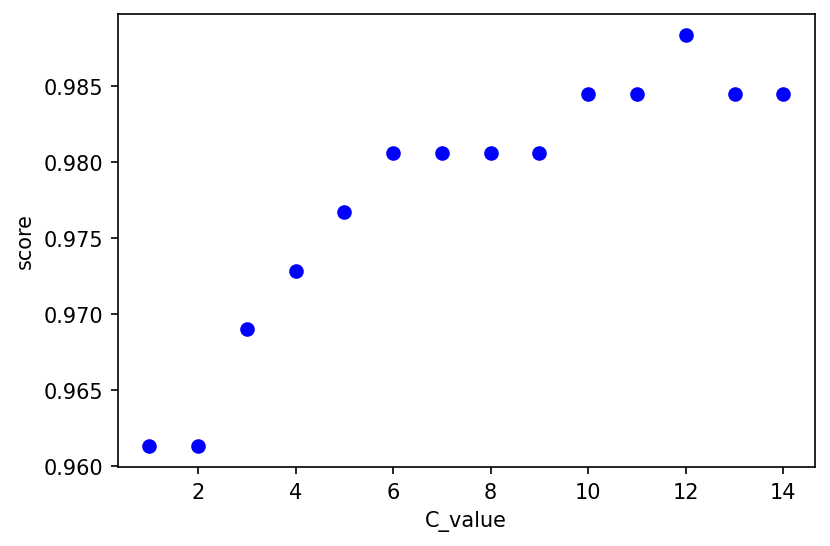

In [18]:
#Finds the best parameters and cv, also shows scatter plot of the C values and their respective score. 
best_param, best_cv = best_C(X_train[best_svm_cols], y_train)

In [19]:
svm = SVC(kernel='poly', C=best_param)
svm.fit(X_train[best_svm_cols], y_train)
svm.score(X_train[best_svm_cols], y_train), svm.score(X_test[best_svm_cols], y_test)

(0.9922779922779923, 0.9692307692307692)

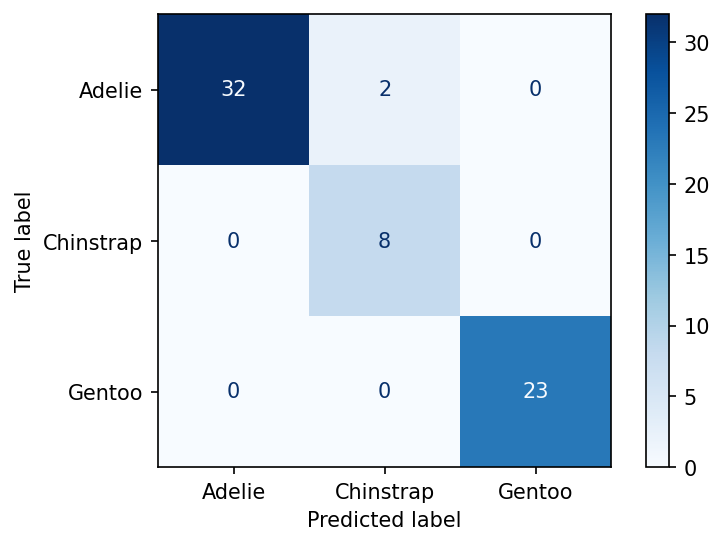

In [20]:
#confusion matrix
plot_confusion_matrix(svm, X_test[best_svm_cols], y_test,
 display_labels= ['Adelie','Chinstrap','Gentoo'],
 cmap = plt.cm.Blues)

In [21]:
# Plotting decision regions

def plot_decision_function(model, df, X, y):
    '''
    Plot the decision region based on model and data set.
    Accepts 4 arguments:
    model: the model being used
    df: data frame to plot
    X: predictor variable of df
    y: target variable of df
    '''

    #fit the model
    target_col = ['Culmen Length (mm)', 'Culmen Depth (mm)']
    model.fit(X[target_col], y)
    
    #record column name and their minimum and maximum values in a dictionary
    range_features = {
    feature_name: (X[feature_name].min() - 1, X[feature_name].max() + 1)
    for feature_name in target_col
    }
    feature_names = list(range_features.keys())

    # evaluate all possible samples in a grid
    xx, yy = np.meshgrid(
        np.arange(range_features[feature_names[0]][0], range_features[feature_names[0]][1], 0.02),
        np.arange(range_features[feature_names[1]][0], range_features[feature_names[1]][1], 0.02)
    )

    # compute the value of associated prediction
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the boundary and the data samples
    fig, ax = plt.subplots()
    ax = sns.scatterplot(data=df, x="Culmen Length (mm)", y= "Culmen Depth (mm)", hue="Species")
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="PuBuGn")
    return ax

<AxesSubplot:xlabel='Culmen Length (mm)', ylabel='Culmen Depth (mm)'>

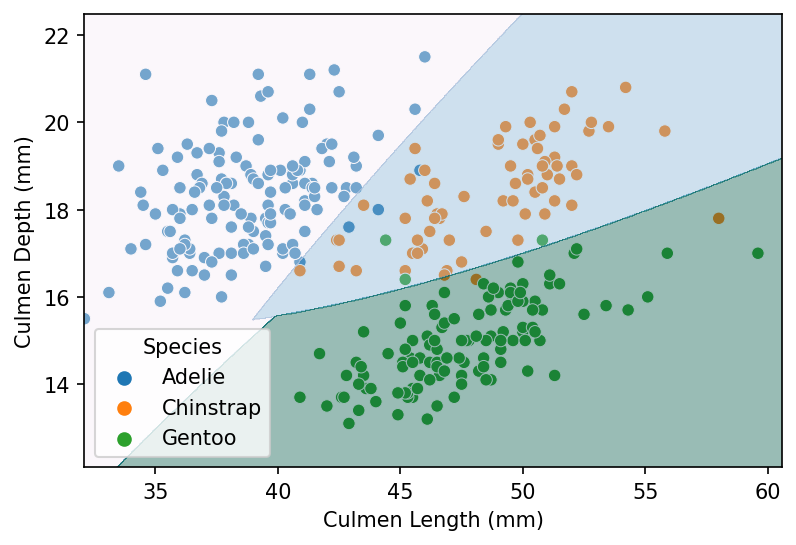

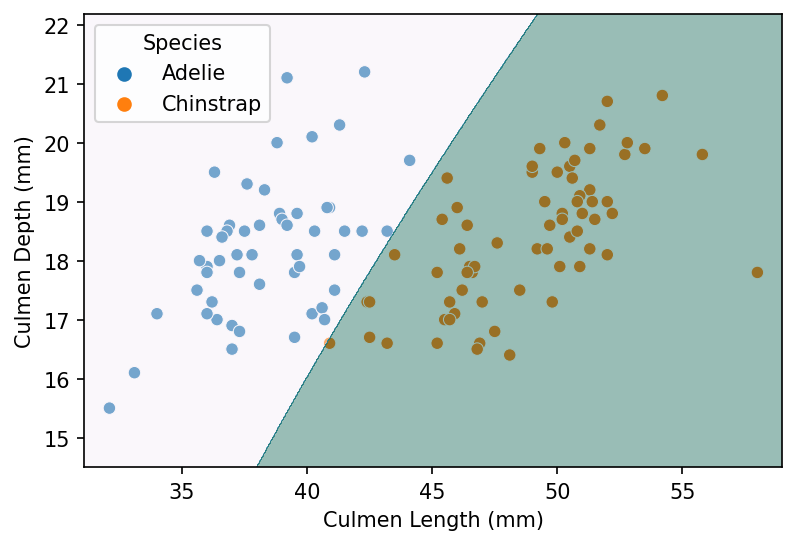

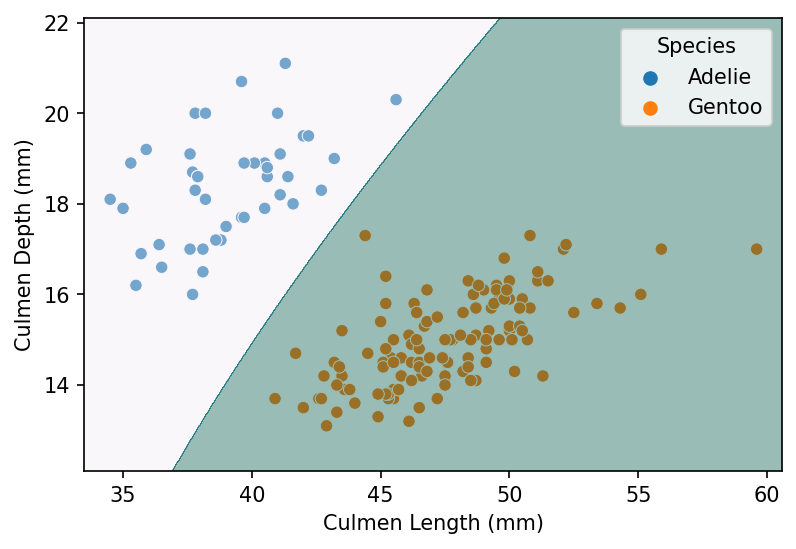

In [22]:
#decision regions
dream_penguins = penguins.loc[penguins["Island"] == "Dream"]
dream_x, dream_y = prep_penguin_data(dream_penguins)

torgersen_penguins = penguins.loc[penguins["Island"] == "Torgersen"]
torgersen_x, torgersen_y = prep_penguin_data(torgersen_penguins)

biscoe_penguins = penguins.loc[penguins["Island"] == "Biscoe"]
biscoe_x, biscoe_y = prep_penguin_data(biscoe_penguins)


plot_decision_function(svm, penguins, X_train, y_train)
plot_decision_function(svm, dream_penguins, dream_x, dream_y)
plot_decision_function(svm, biscoe_penguins, biscoe_x, biscoe_y)

There are two misclassified penguins, based on the result of the confusion matrix. After plotting the result, three Gentoo penguins, three Adelie penguins, and two Chinstrap penguins were classified. For the rest, the model makes perfect classification. Thus, the model performs well.

## Random Forest Model

In [23]:
def prep_penguin_data(data_df):
    '''reset train test and test set'''
    df = data_df.copy()
    df = df[["Island", "Flipper Length (mm)", "Culmen Length (mm)","Species"]]
    le = preprocessing.LabelEncoder()
    df['Island'] = le.fit_transform(df['Island'])
    df['Species'] = le.fit_transform(df['Species'])
    X = df.drop(['Species'], axis = 1)
    y = df['Species']
    return(X, y)
np.random.seed(3354354524)
train, test = train_test_split(df, test_size = 0.2)
#Split data into train and test
X_train, y_train = prep_penguin_data(train)
X_test,  y_test  = prep_penguin_data(test)

In [24]:
#fitting Random Forest Classifier Model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

In [25]:
#train data prediction
y_pred_train = clf.predict(X_train)
y_pred_train

array([2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2,
       0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2,
       2, 1, 1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0,
       1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 0, 0, 1, 2, 2,
       0, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0,
       1, 0, 1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2,
       0, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 1, 0, 2, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 0,
       2, 1, 0, 1, 1, 0, 1, 0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 1, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 2, 1, 0], dtype=int64)

In [26]:
#train data prediction
y_pred_train = clf.predict(X_train)
y_pred_train

array([2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2,
       0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2,
       2, 1, 1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0,
       1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 0, 0, 1, 2, 2,
       0, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0,
       1, 0, 1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2,
       0, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 1, 0, 2, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 0,
       2, 1, 0, 1, 1, 0, 1, 0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 1, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 2, 1, 0], dtype=int64)

In [27]:
#Accuracy on train data prediction
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_train, y_pred_train)

0.9884169884169884

In [28]:
#Test data prediction
y_pred_test = clf.predict(X_test)
y_pred_test

array([2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 2, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 2, 2, 1,
       2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0],
      dtype=int64)

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_test, y_pred_test)

0.9692307692307692

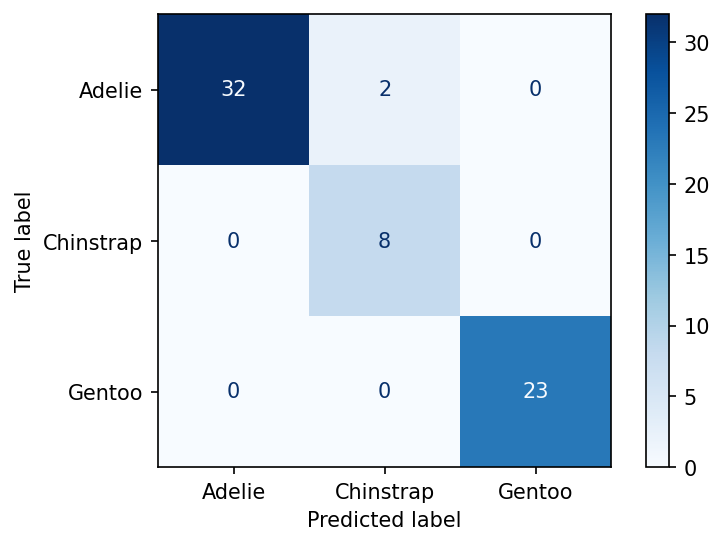

In [30]:
#confusion matrix
best_clf_cols = ["Island", "Flipper Length (mm)", "Culmen Length (mm)"]
clf.fit(X_train[best_clf_cols], y_train)
clf.score(X_train[best_clf_cols], y_train), clf.score(X_test[best_clf_cols], y_test)
plot_confusion_matrix(clf, X_test[best_clf_cols], y_test,
 display_labels= ['Adelie','Chinstrap','Gentoo'],
 cmap = plt.cm.Blues)

<AxesSubplot:xlabel='Flipper Length (mm)', ylabel='Culmen Length (mm)'>

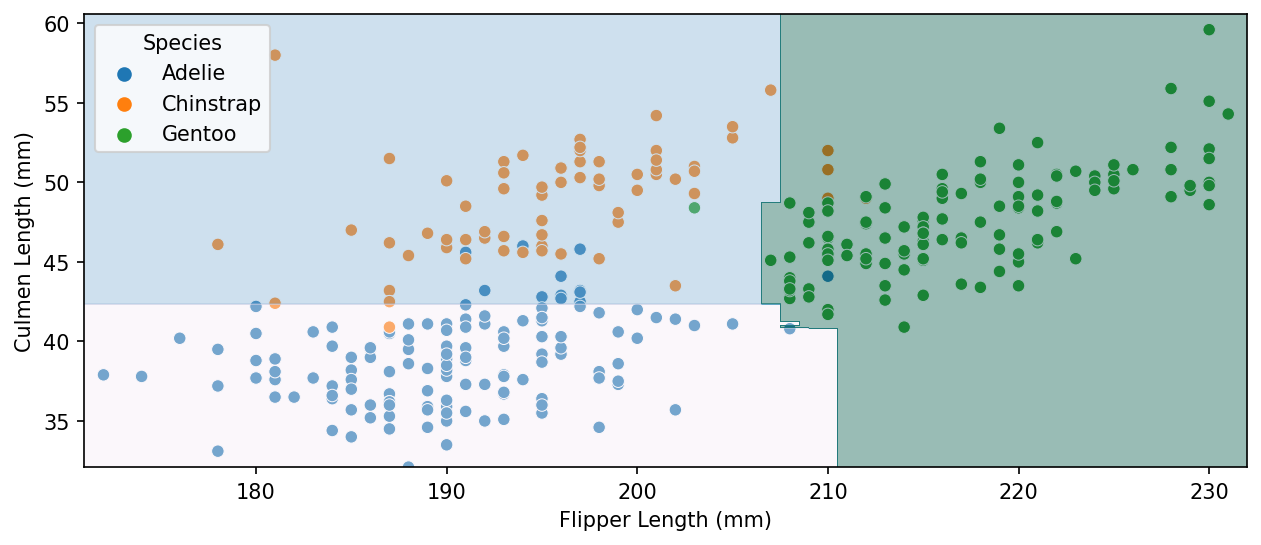

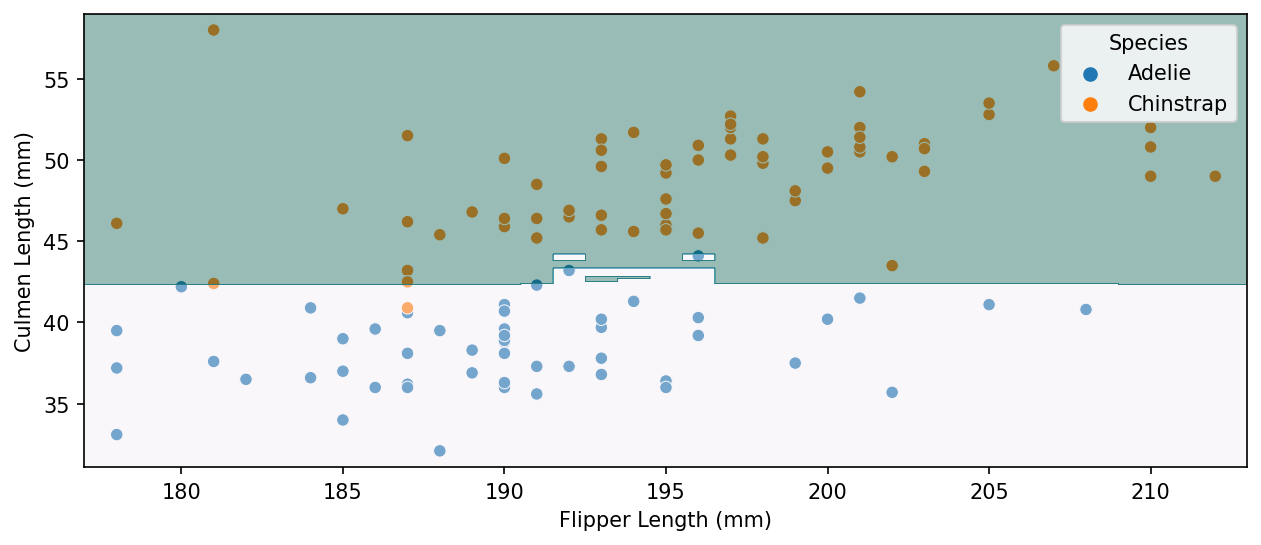

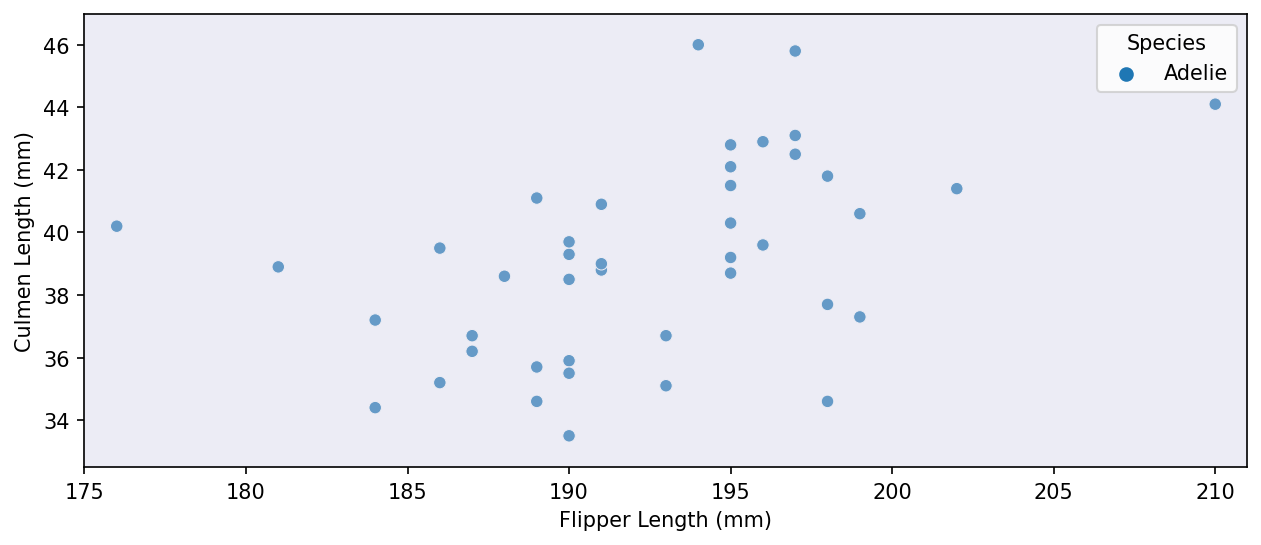

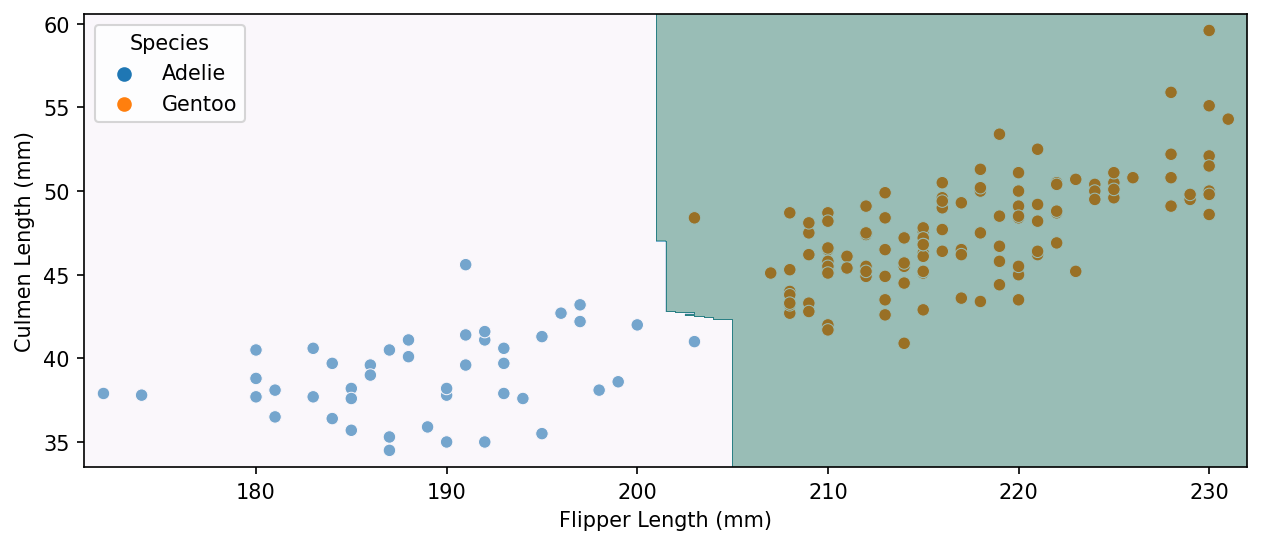

In [31]:
dream_penguins = penguins.loc[penguins["Island"] == "Dream"]
dream_x, dream_y = prep_penguin_data(dream_penguins)

torgersen_penguins = penguins.loc[penguins["Island"] == "Torgersen"]
torgersen_x, torgersen_y = prep_penguin_data(torgersen_penguins)

biscoe_penguins = penguins.loc[penguins["Island"] == "Biscoe"]
biscoe_x, biscoe_y = prep_penguin_data(biscoe_penguins)

def plot_decision_function(model, df, X, y): #Note that different parameters in this function from the previous one led to the recreating of the plot dec function. 
    '''
    Plot the decision region based on model and data set.
    Accepts 4 arguments:
    model: the model being used
    df: data frame to plot
    X: predictor variable of df
    y: target variable of df
    '''

    col1 = ["Flipper Length (mm)", "Culmen Length (mm)"]
    model.fit(X[col1], y)
    
    range_features = {
    feature_name: (X[feature_name].min() - 1, X[feature_name].max() + 1)
    for feature_name in col1
    }
    feature_names = list(range_features.keys())

    xx, yy = np.meshgrid(
        np.arange(range_features[feature_names[0]][0], range_features[feature_names[0]][1],0.02),
        np.arange(range_features[feature_names[1]][0], range_features[feature_names[1]][1], 0.02),
        #np.arange(range_features[feature_names[2]][0], range_features[feature_names[2]][1], 0.02)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 4)
    ax = sns.scatterplot(data=df, x="Flipper Length (mm)", y= "Culmen Length (mm)", hue="Species")
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="PuBuGn")
    return ax

plot_decision_function(clf, penguins, X_train, y_train)
plot_decision_function(clf, dream_penguins, dream_x, dream_y)
plot_decision_function(clf, torgersen_penguins, torgersen_x, torgersen_y) 
plot_decision_function(clf, biscoe_penguins, biscoe_x, biscoe_y)

In this model, twelve Adelie, one gentoo, and four chinstrap penguins were mislabeled. It appears as though the model does not make enough specifications for the Adelie penguins, leading to the outliers of the Adelie being misclassified. 

## Neural Netowrk Model

In [32]:
from sklearn.neural_network import MLPClassifier
np.random.seed(3354354524)

clf = MLPClassifier()
clf.fit(X_train, y_train)
cross_val_score(clf, X_train, y_train, cv = 5).mean(), cross_val_score(clf, X_test, y_test, cv = 5).mean()

D:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.6446455505279035, 0.6307692307692307)

In [33]:
np.random.seed(3354354524)

best_clf_cols = ["Island", "Culmen Depth (mm)", "Culmen Length (mm)"]


clf = MLPClassifier(solver = "lbfgs",max_iter = 500) #the solver parameter was manually changed to test for the best score. there were only four different options
                                                     #so a function was not needed. 
cv_score = cross_val_score(clf, X_train[best_clf_cols], y_train).mean()
clf.fit(X_train[best_clf_cols], y_train) 
cv_score

cross_val_score(clf, X_train[best_clf_cols], y_train).mean(), cross_val_score(clf, X_test[best_clf_cols], y_test).mean()

KeyError: "['Culmen Depth (mm)'] not in index"

In [ ]:
#confusion matrix
plot_confusion_matrix(clf, X_test[best_clf_cols], y_test,display_labels= ['Adelie','Chinstrap','Gentoo'],cmap = plt.cm.Blues)

In [ ]:
#utilizes the plot_decision_function from the Support Vector 
plot_decision_function(clf, penguins, X_train, y_train)
plot_decision_function(clf, dream_penguins, dream_x, dream_y)
plot_decision_function(clf, biscoe_penguins, biscoe_x, biscoe_y)
plot_decision_function(clf, torgersen_penguins, torgersen_x, torgersen_y) 

As seen in the first decision region, the model misclassified four Adelie penguins, three Chinstrap penguins, and two Gentoo penguins. Unlike the Support Vector Model, the neural network model separates all of the regions by straight lines. This leads to the misclassifying of certain penguins with whose measurements are outliers from the rest of the species. 

## Discussion

Overall, all of the models all performed well on both the training and testing data. However, the Support Vector Model performed the best overall. The Neural Network model performed higher than the Support Vector Model on the training data, albeit only by a slim margin. The Support Vector Model performed better by a larger margin than the other two on the testing data. 


For the features, both the function and graphs confirm that the Island column is the best qualitative column to use. Additionally, the first function and the graphs show that the Culmen Length and Culmen Depth columns are also the best measurements to use. 


There are two misclassified penguins, based on the result of the confusion matrix. After plotting the result, three Gentoo penguins, two Adelie penguins, and two Chinstrap penguins were classified. For the rest, the model makes perfect classification. Thus, the model performs well.